# MLflow Tutorial

MLflow is an open source platform for managing the end-to-end machine learning lifecycle. In this notebook we will walk through some of its capabilities focusing on how tracking works, what a project is, and MLflow models.

### Create project files

An MLproject file and yaml file are important for packaging a project so that other Data Scientists can easily reuse the model or so that you can run the training remotely, for example Databricks.

The MLproject file specifies entry points, name, and conda environment file for the project.

In [ ]:
%%writefile "MLproject"

name: tutorial

conda_env: conda.yaml

entry_points:
  main:
    parameters:
      alpha: {type: float, default: 0.01}
      l1_ratio: {type: float, default: 0.1}
    command: "python train_diabetes.py {alpha} {l1_ratio}"

In [60]:
%%cmd
more "MLproject"

Microsoft Windows [Version 10.0.18362.836]
(c) 2019 Microsoft Corporation. All rights reserved.

C:\Users\ChristopherBowers\Documents\MLflow_Tutorial>more "MLproject"

name: tutorial

conda_env: conda.yaml

entry_points:
  main:
    parameters:
      alpha: {type: float, default: 0.01}
      l1_ratio: {type: float, default: 0.1}
    command: "python train_diabetes.py {alpha} {l1_ratio}"

C:\Users\ChristopherBowers\Documents\MLflow_Tutorial>

The yaml file specifies the projects dependencies.

In [ ]:
%%writefile "conda.yaml"

name: tutorial
channels:
  - defaults
  - anaconda
  - conda-forge
dependencies:
  - cloudpickle=0.6.1
  - python=3.6
  - numpy=1.14.3
  - matplotlib=3.0.2
  - pandas=0.22.0
  - scikit-learn=0.19.1
  - pip
  - pip:
    - mlflow

In [61]:
%%cmd
more "conda.yaml"

Microsoft Windows [Version 10.0.18362.836]
(c) 2019 Microsoft Corporation. All rights reserved.

C:\Users\ChristopherBowers\Documents\MLflow_Tutorial>more "conda.yaml"

name: tutorial
channels:
  - defaults
  - anaconda
  - conda-forge
dependencies:
  - cloudpickle=0.6.1
  - python=3.6
  - numpy=1.14.3
  - matplotlib=3.0.2
  - pandas=0.22.0
  - scikit-learn=0.19.1
  - pip
  - pip:
    - mlflow

C:\Users\ChristopherBowers\Documents\MLflow_Tutorial>

### Import libraries

Importing the required libraries for this tutorial.

In [1]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets
import mlflow
import mlflow.sklearn
from mlflow import log_param, log_metric, log_artifact
from mlflow.sklearn import log_model

### Set tracking uri

This sets the tracking location. Once information is logged this uri will be used to send it to the correct location. In this case a remote cluster.

In [2]:
remote_server_uri = "http://38.102.178.57:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
# Note: on Databricks, the experiment name passed to mlflow_set_experiment must be a
# valid path in the workspace

Enter the uri into a web browser and click on your experiments name to view your experiment.

### Set Experiment
Setting the experiment lets MLflow know what experiment the next run should be logged under. Other experiments with the same name are grouped together so that differences between runs are easy to see.

In [64]:
mlflow.set_experiment("another-experiment")

### Load data

Loading data and labeling the target feature.

In [ ]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = diabetes.feature_names + ['progression']
data = pd.DataFrame(d, columns=cols)

### Set-up evaluation function

This is a wrapper function that calculates three metrics and returns them as a tuple.

In [5]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)    
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

### Train Test Split

Performing a Train Test Split to keep a portion of the data "unseen" by the model during training.

In [54]:
train, test = train_test_split(data, random_state=40)
train_x = train.drop(["progression"], axis=1)
test_x = test.drop(["progression"], axis=1)
train_y = train[["progression"]]
test_y = test[["progression"]]

### Create Model

Defining the model and hyper parameters below. The model is then evaluated and the metrics from the eval_metrics function we created earlier are printed.

In [8]:
alpha = 0.05
l1_ratio = 0.05

lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
lr.fit(train_x, train_y)
predicted_qualities = lr.predict(test_x)
(rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

### Logging model data and meta data

An mlflow run is started. Any metrics, parameters, or artifacts can now be logged for this run. Here we have logged the alpha, l1 ratio, and all three performance metrics from our eval_metrics function. In addition to parameters and metrics artifacts can be logged. The last line of code here logs the model we've created and registers it as 'ElasticnetDiabetesModel'.

Much like experiments registered models have a history. Lineage, versionoing, stage transitions, and annotations are all recorded and kept track of.

In [72]:
mlflow.start_run()
log_param("alpha", alpha)
log_param("l1_ratio", l1_ratio)
log_metric("rmse", rmse)
log_metric("r2", r2)
log_metric("mae", mae)
#log_model(lr, artifact_path=remote_server_uri + '/mlruns/4/model', registered_model_name='ElasticnetDiabetesModel')

### Logging other artifacts

Other artifacts can be logged from runs as well. the script below creates a plot of the regularization path using the elastic net. The last line logs that graph to this run as an artifact.

Computing regularization path using the elastic net.


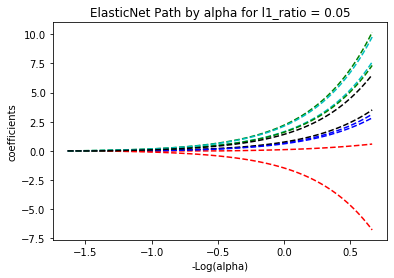

In [71]:
eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the elastic net.")
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)

fig = plt.figure(1)
ax = plt.gca()
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_e, c in zip(coefs_enet, colors):
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)
    

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
title = 'ElasticNet Path by alpha for l1_ratio = ' + str(l1_ratio)
plt.title(title)
plt.axis('tight')

fig.savefig("ElasticNet-paths.png")
#log_artifact("ElasticNet-paths.png", artifact_path='./mlruns/4/')
mlflow.end_run()